#Power Plant regression

In this practice, we will work on a modified version of the Kaggle dataset:
[Power Plant Data(Customized for Linear Regression)](https://www.kaggle.com/datasets/fernandowolff/power-plant-data-customized-for-linear-regression/data)


We modified the file and added artifical outliers to the original dataset.


### Part 1: Outlier Detection and Removal using Cook's Distance

1.1 Model choice
- Among Linear Regression, Ridge Regression, and Lasso Regression, I will choose Linear Regression as the model because now we want to identify the outliers first. Cook's Distance is derived for OLS regression. Using OLS ensures that the influence diagnostics have a clear and standard interpreation.

- Among statsmodels and scikit-learn, I want to choose statsmodels because we want to detect and prove which points are outliers, and it's easier to use tools like Cook's Distance to statistically identify those outliers influencing my power output predictions.

In [41]:
# === Imports ===
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

import statsmodels.api as sm


import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)


from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# === Load dataset ===
DATA_PATH = "/content/drive/MyDrive/EE344/week3/usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())

target_col = df.columns[-1]  # Power Output
print("Target column:", target_col)

Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE


1.2 Identify outliers, remove them, and export clean CVS
- Now, we will computer Cook's distance for each data point and using the standard rules(4/n) as a threshold to identify outliers.
- Then, we will remove the detected outliers and creat a new DataFrame without outliers.

In [15]:
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']

X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()

influence = model.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(df)
threshold = 4 / n

# Identify outliers
outliers = df[cooks_d > threshold]
print(f"Number of outliers detected: {len(outliers)}")

# Remove outliers
df_clean = df[cooks_d <= threshold]


Number of outliers detected: 120
(9448, 5)
(9568, 5)


In [10]:
df_clean.to_csv('/content/drive/MyDrive/EE344/week3/usina.csv', index=False)

### Part 2: Train/Test Evaluation Before vs After Outlier Removal

A general step to perform here is to first split the dataset to 70/30 for training and testing data, train the Linear Regression, Ridge Regression, and Lasso Regression model on the dataset and report the train/test metrics.

For Ridge and Lasso, we will use the following $\lambda$ values: $\lambda \in \{0.001, 0.1, 1, 10, 100\}$

In [16]:
df_outliers = pd.read_csv("/content/drive/MyDrive/EE344/week3/usina_with_outliers.csv")
df_clean = pd.read_csv("/content/drive/MyDrive/EE344/week3/usina.csv")

target = 'PE'

# Split both datasets (70/30 split with fixed state)
X_out = df_outliers.drop(columns=[target]).copy()
y_out = df_outliers[target]
X_clean = df_clean.drop(columns=[target]).copy()
y_clean = df_clean[target]


X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(X_out, y_out, test_size=0.30, random_state=42, shuffle=True)
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_clean, y_clean, test_size=0.30, random_state=42, shuffle=True)


print("Train_out:", X_train_out.shape, y_train_out.shape)
print("Test_out:", X_test_out.shape, y_test_out.shape)

print("Train_cl:", X_train_cl.shape, y_train_cl.shape)
print("Test_cl:", X_test_cl.shape, y_test_cl.shape)

Train_out: (6697, 4) (6697,)
Test_out: (2871, 4) (2871,)
Train_cl: (6613, 4) (6613,)
Test_cl: (2835, 4) (2835,)


In [18]:
# === Helper functions ===
def eval_metrics(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    return {
        "train_MAE": mean_absolute_error(y_train, y_train_pred),
        "train_MSE": mean_squared_error(y_train, y_train_pred),
        "train_R2": r2_score(y_train, y_train_pred),
        "test_MAE": mean_absolute_error(y_test, y_test_pred),
        "test_MSE": mean_squared_error(y_test, y_test_pred),
        "test_R2": r2_score(y_test, y_test_pred)
    }



2.1 Let's first check the one with outliers

In [25]:
results_out = {}

results_out["Linear"] = eval_metrics(
    LinearRegression(),
    X_train_out, X_test_out,
    y_train_out, y_test_out
)
lambdas = [0.01, 0.1, 1, 10, 100]

for lam in lambdas:
    results_out[f"Ridge_{lam}"] = eval_metrics(
        Ridge(alpha=lam),
        X_train_out, X_test_out,
        y_train_out, y_test_out
    )

    results_out[f"Lasso_{lam}"] = eval_metrics(
        Lasso(alpha=lam, max_iter=10000),
        X_train_out, X_test_out,
        y_train_out, y_test_out
    )

results_out_df = pd.DataFrame(results_out).T
results_out_df

,train_MAE,train_MSE,train_R2,test_MAE,test_MSE,test_R2
Linear,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
Ridge_0.01,5.198679,123.384207,0.650171,5.052458,125.113389,0.642574
Lasso_0.01,5.198858,123.384210,0.650171,5.052626,125.115332,0.642568
Ridge_0.1,5.198680,123.384207,0.650171,5.052459,125.113392,0.642574
Lasso_0.1,5.201739,123.384607,0.650169,5.055348,125.134495,0.642514
Ridge_1,5.198685,123.384207,0.650171,5.052463,125.113421,0.642574
Lasso_1,5.229507,123.421151,0.650066,5.083092,125.338356,0.641931
Ridge_10,5.198737,123.384207,0.650171,5.052513,125.113705,0.642573
Lasso_10,5.540418,126.141514,0.642353,5.408803,128.902136,0.631750
Ridge_100,5.199261,123.384213,0.650171,5.053003,125.116548,0.642565


2.2 Now, let's deal with the clean version

In [27]:
results_cl = {}

results_cl["Linear"] = eval_metrics(
    LinearRegression(),
    X_train_cl, X_test_cl,
    y_train_cl, y_test_cl
)
lambdas = [0.01, 0.1, 1, 10, 100]

for lam in lambdas:
    results_cl[f"Ridge_{lam}"] = eval_metrics(
        Ridge(alpha=lam),
        X_train_cl, X_test_cl,
        y_train_cl, y_test_cl
    )

    results_cl[f"Lasso_{lam}"] = eval_metrics(
        Lasso(alpha=lam, max_iter=10000),
        X_train_cl, X_test_cl,
        y_train_cl, y_test_cl
    )

results_cl_df = pd.DataFrame(results_cl).T
results_cl_df

,train_MAE,train_MSE,train_R2,test_MAE,test_MSE,test_R2
Linear,3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
Ridge_0.01,3.596396,19.864671,0.931369,3.624773,20.396772,0.930302
Lasso_0.01,3.596368,19.864675,0.931369,3.624754,20.396738,0.930302
Ridge_0.1,3.596397,19.864671,0.931369,3.624773,20.396770,0.930302
Lasso_0.1,3.596855,19.865263,0.931367,3.624890,20.392600,0.930316
Ridge_1,3.596400,19.864671,0.931369,3.624774,20.396750,0.930302
Lasso_1,3.605523,19.929852,0.931144,3.631153,20.414755,0.930241
Ridge_10,3.596430,19.864672,0.931369,3.624783,20.396549,0.930303
Lasso_10,4.086632,25.685683,0.911258,4.120464,26.157253,0.910618
Ridge_100,3.596742,19.864758,0.931369,3.624880,20.394626,0.930310


Discussion:
- Comparing the 2 charts, we can clearly see that in both train and test, MSE and MAE values of the dataset with outliers is much bigger, and R^2 value is further away from 1. So, we can conclude that outliers change both train error and test error.
- The clean dataset without any outliers shows better generalization. Because it has a higher R^2 value. (For example, for linear regression, the R^2 value increases from 0.64 to 0.93, and for Ridge_0.01 and Lasso_0.01, same thing happened) Additionally,the smaller gap between train and test in clean dataset also suggests that it's more stable.

- In this case, Ridge and Lasso regression do not provide a substantial improvemnet over standard linear regression. Because by viewing the result, the best Ridge and Lasso models, i.e.Lasso_0.1 with a R^2 value of 0.930316; Ridge_100, 0.930310, got the result very close to linear regression, 0.930302.

### Part 3: Reliability of Coefficients

Now, we want to understand how important each coefficient is, and to justify the most reliable coefficient and the least reliable coefficient. In this part, we will use outlier-removed dataset only.

- I choose Linear Regression model. Because the goal now is to calculate reliability, which means we need to calculate t-statistics and p-values. Regularized models like Ridge or Lasso will introduce bias to reduce variance, which is not our goal.

3.1
- I choose statsmodels OLS. Because similar to part 1, it can provide a comprehensive summary table including standard errors, t-values, and p-values, which are crucial tools for measuring reliability.
- I will not scale IVs and DV for this task because scaling changes the raw coefficient values but does not change the t-statistic or the p-value. Since reliability is based on the probability of the coefficient being non-zero, the result remains identical whether the data is scaled or unscaled.

3.2
Now, let's fit our OLS regression model on the clean dataset and use the standard errors, t-statistics and p value of the coefficients to access reliability. The larger absolute t-statistic, more reliable the coefficient is.

In [29]:
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

X_with_const1 = sm.add_constant(X)
model1 = sm.OLS(y, X_with_const1).fit()

print(model1.summary())
# build table
reliability_table = pd.DataFrame({
    "Coefficient": model1.params,
    "Standard Error": model1.bse,
    "t-statistic": model1.tvalues,
    "p-value": model1.pvalues
})

# Sort by absolute t-statistic to find reliability
reliability_sorted = reliability_table.reindex(reliability_table['t-statistic'].abs().sort_values(ascending=False).index)
print("\nCoefficients ranked by reliability (Absolute t-statistic):")
print(reliability_sorted.drop('const'))

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Fri, 30 Jan 2026   Prob (F-statistic):               0.00
Time:                        03:31:22   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        440.9993      9.743     45.265      0.0

Based on the coefficient table, we can see that AP has the least absolute t-statistic value among all, which means that it's the least reliable coefficient. It means that the effect of it is relatively traivial. We can also see that AT has the largest absolute t-statistic value, which means that it's the most reliable coefficient. This suggests that ambient temperature has a stable and strong relationship with power output.

### Part 4: Most Important vs Least Important Features

In this part, we will also use te outlier-removed dataset.

4.1
- For the model, I chose Linear Regression because similar in the case study, feature importances in a linear model is directly measured by the magnitude of the regression coefficients. So it's easy to observe and justify.
- I chose statsmodels OLS because it provides a lot of useful tools when we want to get access to model coefficients.
- I scaled the IVs because they all have different units and different value range, so by scaling it, we can make the coefficient comparison fair. We don't need to scale DV because there's only 1 Dv and it will not change relative feature importance.



In [30]:

def standardized_coeff_table(model, features):
    coef = model.params[1:]
    table = pd.DataFrame({
        "feature": features,
        "standardized_coef": coef
    })
    return table.sort_values(
        "standardized_coef", key=np.abs, ascending=False
    )

In [38]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_with_const1 = sm.add_constant(X_scaled)
model1 = sm.OLS(y, X_with_const1).fit()

features=['AT', 'V', 'AP', 'RH']
importance_table = standardized_coeff_table(model1, features)
display(importance_table)

,feature,standardized_coef
x1,AT,-14.556614
x2,V,-3.030737
x4,RH,-2.197120
x3,AP,0.442513


Based on the table, we can see that AT has the largest absolute coefficient, which indicates that ambient temperature is the most important feature in the model, which means that it can impact the resulting power output the most.

We can also see that AP has the smallest absolute coefficient, whcih indicates that it is the least important feature among all.

### Part 5: Regulaization Paths

In this part, we will continue using the clean dataset.


Here, we want to know how regression coefficients change as the regularization parameter $\lambda$ change. We will implement both Ridge Regression and Lasso Regression. We pkot coefficient value vs $\lambda$ for both Ridge and Lasso. In this case, we will choose a log-spaced range of $\lambda$ so we will be able to see a pattern.



In [39]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

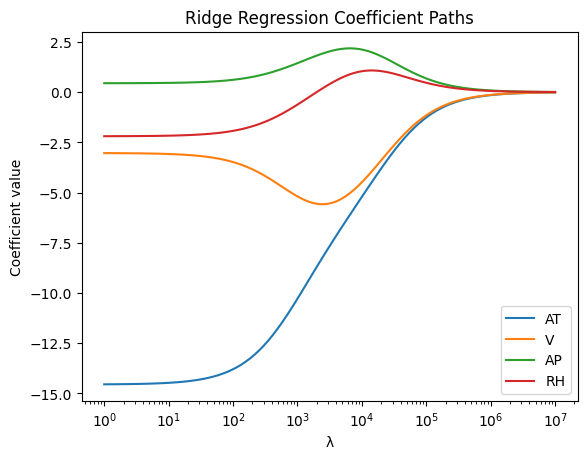

In [48]:
lambdas = np.logspace(0,7,100)
ridge_coefs = []
for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)
ridge_coefs = np.array(ridge_coefs)

# Plot
plt.figure()
for i, f in enumerate(features):
    plt.plot(lambdas, ridge_coefs[:, i], label=f)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Ridge Regression Coefficient Paths")
plt.legend()
plt.show()


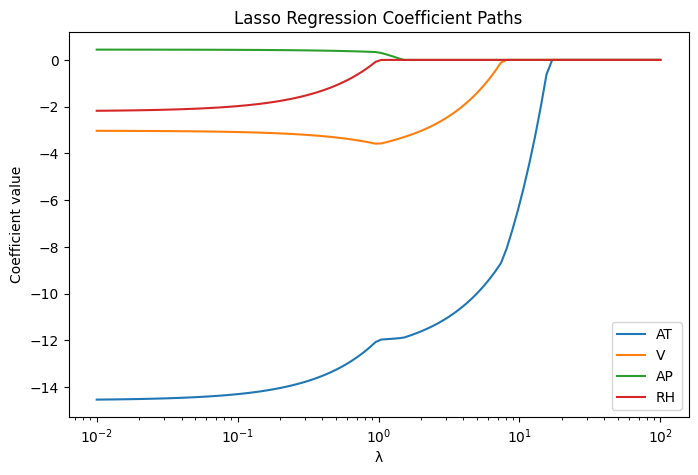

In [49]:
lambdas = np.logspace(-2, 2, 100)
lasso_coefs = []
for lam in lambdas:
    lasso = Lasso(alpha=lam, max_iter=10000)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

lasso_coefs = np.array(lasso_coefs)

plt.figure(figsize=(8, 5))
for i, f in enumerate(features):
    plt.plot(lambdas, lasso_coefs[:, i], label=f)

plt.xscale("log")
plt.xlabel("λ")
plt.ylabel("Coefficient value")
plt.title("Lasso Regression Coefficient Paths")
plt.legend()
plt.show()

From the regularization path plots, we can conclude the behavior of Ridge regression and Lasso regression.

For Ridge regression, as $\lambda$ increases, different features showed different patterns, but they are all growing from their initial value, experiences a small increase or decrease, and shrink to 0 in the end. This means that Ridge keeps all the feature while managing their impact to 0 smoothly.

For Lasso regression, the pattern is very different. We can see that there's a "turning point" for each of the features. The lines are not smooth. And in the end, all the features become 0, but some of them vanish first. This means that Lasso Regression will do feature selection by asignning 0 to some of their features with a smaller impact to the result at some point.

In general, Ridge Regression is generally better for multicollinearity because it shrinks correlated features instead of removing unimportant ones. But when it comes to feature selection, Lasso is better because it automatically select some important features.